# Projeto Final de Ciência de Dados

## Bibliotecas

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

## Introdução

Nome dos integrantes:

- **Nome**: Alan Teixeira da Costa, **Matrícula**: 2022100831, **E-mail**: alan.costa@edu.ufes.br
- **Nome**: Miguel Vieira Machado Pim, **Matrícula**: 2022100894, **E-mail**: miguel.pim@edu.ufes.br

O objetivo geral deste projeto final é praticar os conceitos estudados durante toda a disciplina de Introdução a Ciência de Dados, principalmente: web scraping e aprendizado supervisionado. Para isso iremos fazer scraping do site https://www.transfermarkt.com.br/ para poder prever resultados de partidas de futebol a partir de dados da premier league e do brasileirão.

## Descrição de Problema

Nosso problema consiste em construir um classificador capaz de prever resultados de partidas de futebol. Este classificador deverá classificar uma partida entre três possíveis resultados: vitória do time da casa, derrota do time da casa ou empate.

## Descrição do Conjunto de Dados

Para este projeto utilizaremos um conjunto de dados de partidas de futebol. Os dados foram obtidos utilizando web scraping para buscar partidas de ligas. O código do scraping pode ser visto no repositório https://github.com/Alan-TC/Scraper-T2-CienciaDeDados. Vale ressaltar que utilizamos apenas os dados de partidas de ligas desse repositório. No [script_concatenação](./pre_processer.ipynb) foi feito a transformação de todos os dataframes em apenas um.

Os dados estão organizados em um arquivo (```partidas.csv```) com as seguintes colunas:  

Colunas com informações sobre a partida, indepedente do time:  
- **capacidade_estadio**: Capacidade do estádio do time da casa (```int```)
- **publico_estadio**: Público total que compareceu ao jogo (```int```)
- **ano**: Ano em que o jogo aconteceu (```int```)
- **fase**: Rodada da liga em que o jogo aconteceu (```str```)  

Colunas com informações sobre os times. No arquivo, para cada coluna com "casa" no nome também existe uma coluna com "fora" no nome, que foram omitidas por terem características iguais:
- **time_casa**: Nome do time da casa (```str```)
- **gols_casa**: Quantidade de gols do time da casa (```int```)
- **posse_casa**: Quantidade de posse de bola do time da casa em porcentagem (```int```)
- **tentativas_casa**: Quantidade de chutes do time da casa (```int```)
- **chutes_fora_casa**: Quantidade de chutes pra fora do gol da casa (```int```)
- **defesa_casa**: Quantidade de defesas do goleiro do time da casa (```int```)
- **escanteios_casa**: Quantidade de escanteios do time da casa (```int```)
- **cobrancas_falta_casa**: Quantidade de cobranças de falta do time da casa (```int```)
- **faltas_cometidas_casa**: Quantidade de faltas cometidas pelo time da casa (```int```)
- **impedimentos_casa**: Quantidade de impedimentos do time da casa (```int```)

Portanto, no total temos 24 colunas do nosso dataframe.

In [116]:
partidas_df = pd.read_csv("partidas.csv")
partidas_df.head()

,capacidade_estadio,publico_estadio,time_casa,gols_casa,posse_casa,tentativas_casa,chutes_fora_casa,defesa_casa,escanteios_casa,cobrancas_falta_casa,...,posse_fora,tentativas_fora,chutes_fora_fora,defesa_fora,escanteios_fora,cobrancas_falta_fora,faltas_cometidas_fora,impedimentos_fora,ano,fase
0,26047,0,Crystal Palace FC,1,30,5,2,5,7,10,...,70,9,3,2,3,14,11,0,2021,1.Rodada
1,54074,0,FC Liverpool,4,49,22,3,0,9,5,...,51,6,1,3,0,9,6,5,2021,1.Rodada
2,60000,0,West Ham United,0,58,15,5,0,8,7,...,42,15,7,3,7,11,7,4,2021,1.Rodada
3,2685,0,West Bromwich Albion,0,37,7,3,4,2,9,...,63,13,3,1,5,11,9,3,2021,1.Rodada
4,62062,0,Tottenham Hotspur,0,51,9,1,3,5,6,...,49,15,7,5,3,14,7,1,2021,1.Rodada


## Metodologia

Para atingir o objetivo proposto utilizaremos os seguintes passos:  

- Pré-processamento dos dados (retirar colunas desnecessárias dos dados e adicionar a coluna com as labels).
- Aplicação de ao menos dois algoritmos de aprendizado supervisionado vistos em aula.
- Validação da metodologia utilizada.
- Interpretação dos resultados.

## Pré-processamento

### Adicionando coluna label

Os valores dos labels serão:  

- **0**: Vitória do time da casa
- **1**: Empate
- **2**: Derrota do time da casa

In [117]:
def add_label_column(row):
    if (row["gols_casa"] > row["gols_fora"]):
        return 0
    elif (row["gols_casa"] < row["gols_fora"]):
        return 1
    else:
        return 2

In [118]:
partidas_df["label"] = partidas_df.apply(add_label_column, axis=1)
partidas_df[["gols_casa", "gols_fora", "label"]].head()

,gols_casa,gols_fora,label
0,1,0,0
1,4,3,0
2,0,2,1
3,0,3,1
4,0,1,1


### Transformando coluna da fase

In [119]:
partidas_df["fase"] = list(map(lambda x : int(x.split('.')[0]), partidas_df["fase"]))
partidas_df["fase"].head()

0    1
1    1
2    1
3    1
4    1
Name: fase, dtype: int64

### Retirando colunas desnecessárias

In [120]:
partidas_df.drop(columns=["time_casa", "time_fora", "gols_casa", "gols_fora"], inplace=True)
partidas_df.head()

,capacidade_estadio,publico_estadio,posse_casa,tentativas_casa,chutes_fora_casa,defesa_casa,escanteios_casa,cobrancas_falta_casa,faltas_cometidas_casa,impedimentos_casa,...,tentativas_fora,chutes_fora_fora,defesa_fora,escanteios_fora,cobrancas_falta_fora,faltas_cometidas_fora,impedimentos_fora,ano,fase,label
0,26047,0,30,5,2,5,7,10,14,4,...,9,3,2,3,14,11,0,2021,1,0
1,54074,0,49,22,3,0,9,5,9,2,...,6,1,3,0,9,6,5,2021,1,0
2,60000,0,58,15,5,0,8,7,13,2,...,15,7,3,7,11,7,4,2021,1,1
3,2685,0,37,7,3,4,2,9,12,4,...,13,3,1,5,11,9,3,2021,1,1
4,62062,0,51,9,1,3,5,6,15,0,...,15,7,5,3,14,7,1,2021,1,1


### Verificando a proporção de vitória, derrota e empate para o time da casa

<Axes: ylabel='Count'>

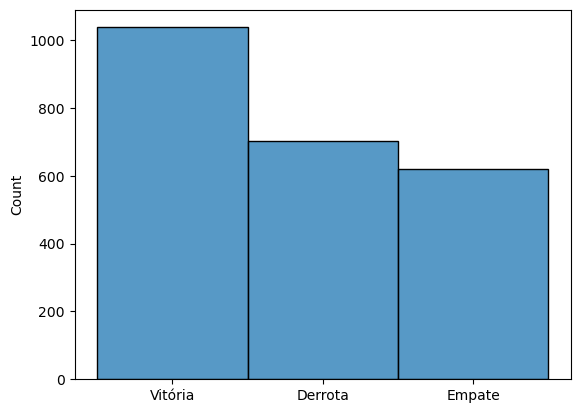

In [121]:
sns.histplot([(lambda x: 'Vitória' if x == 0 else 'Derrota' if x == 1 else 'Empate')(x) for x in partidas_df['label']])

## Aplicando algoritmos de classificação

Separando partidas_df em x e y:

In [122]:
y = partidas_df["label"]
X = partidas_df.drop(columns=["label"])

### KNN

#### Separando conjunto de treino(70%) e teste(30%)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

#### Escolha do K

In [124]:
k_range = range(1, 50)
k_scores = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors = k)
    scaler = preprocessing.MinMaxScaler(feature_range = (0, 10))
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring='accuracy')
    k_scores.append(scores.mean())

Text(0, 0.5, 'Acurácia do KNN')

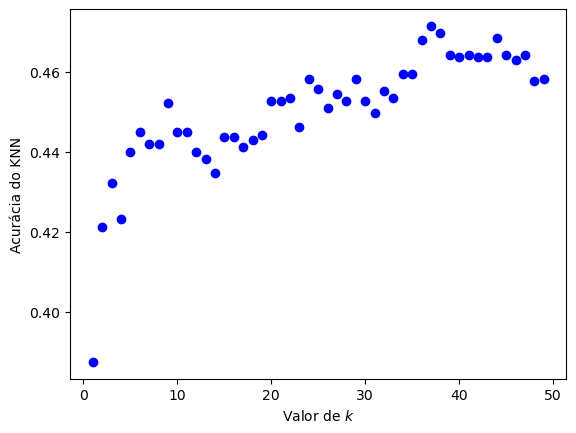

In [125]:
plt.scatter(k_range, k_scores, color = 'blue')
plt.xlabel(r'Valor de $k$')
plt.ylabel('Acurácia do KNN')

#### Normalizando - Definindo o scaler

In [126]:
scaler = preprocessing.MinMaxScaler(feature_range = (0, 10))
scaler.fit(X_train)

MinMaxScaler(feature_range=(0, 10))

#### Realizando o treinamento

In [127]:
k = 29
model = KNeighborsClassifier(n_neighbors = k)
X_train_scaled = scaler.transform(X_train)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=29)

#### Obtendo predição do conjunto de teste

In [128]:
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

#### Avaliando o classificador

In [129]:
acc = accuracy_score(y_test, y_pred)
print("Acurácia do Classificador = %f" % acc)

Acurácia do Classificador = 0.454802


## Resultados

## Conclusões e Discussões